In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.stats import zscore
from wordcloud import WordCloud

import os


In [2]:
#os.mkdir("temporal_analysis/figures")
#os.mkdir("spread_of_influence/figures")

In [3]:
## Politicians and Journalists by Support
pol_tweets = pd.read_csv("temporal_analysis/tweets_distribution.csv")
pol_tweets.created_at = pd.to_datetime(pol_tweets.created_at)

In [4]:
## Number of users by support
pol_tweets[["support", "user"]].drop_duplicates().support.value_counts()

no     120
yes    120
Name: support, dtype: int64

In [5]:
## Number of tweets by support
pol_tweets.support.value_counts()

no     16448
yes    14827
Name: support, dtype: int64

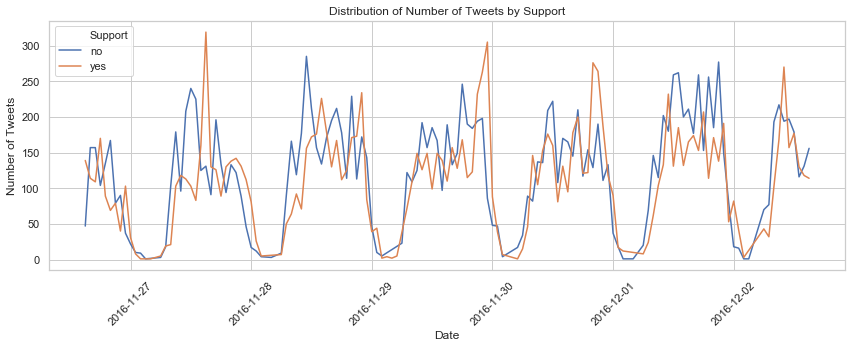

In [6]:
## Temporal Behaviour
agg_tweets = pol_tweets.groupby(["support", "created_at"]).support.count()
agg_tweets = pd.DataFrame(agg_tweets).rename(
    columns={"support":"number_of_tweets"}
).reset_index()
agg_tweets = agg_tweets.rename(columns={"support":"Support"})
plt.figure(figsize=(12, 5))
sns.set(font_scale=1)
sns.set_style("whitegrid")
g = sns.lineplot(data=agg_tweets, x="created_at", y="number_of_tweets", hue="Support")
g.set(xlabel='Date', ylabel='Number of Tweets')
plt.xticks(rotation=45)
plt.title("Distribution of Number of Tweets by Support")


plt.tight_layout()
g.figure.savefig("temporal_analysis/figures/temporal_distribution.png")

In [7]:
## Create word cloud for clusters
def clusters_wordcloud(data, support="yes"):
    fig = plt.figure(figsize=(12, 8))
    grid = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
    subgrid = grid[0].subgridspec(1, 2)
    grid_axes = [subgrid[0, 0], subgrid[0, 1], grid[1, 0]]
    wordcloud = WordCloud(background_color='white')
    for i in range(1, 4):
        freq = data.loc[
            (clusters.cluster == i) & 
            (clusters.support== support)
        ][[
            "term", "number_of_tweets"
        ]].set_index("term").to_dict()["number_of_tweets"]
        wordcloud.generate_from_frequencies(frequencies=freq)
        fig.add_subplot(grid_axes[i-1])
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title("Cluster {}".format(i))
        plt.axis("off")
    plt.savefig(
        'temporal_analysis/figures/clusters_{}.png'.format(support)
    )

In [8]:
clusters = pd.read_csv("temporal_analysis/clusters.csv")

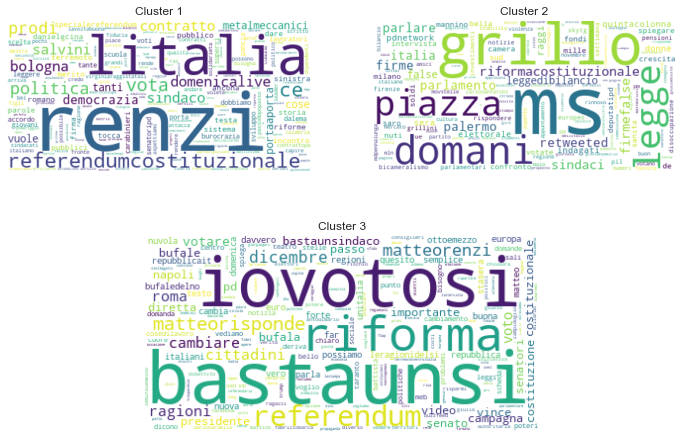

In [9]:
clusters_wordcloud(clusters, "yes")

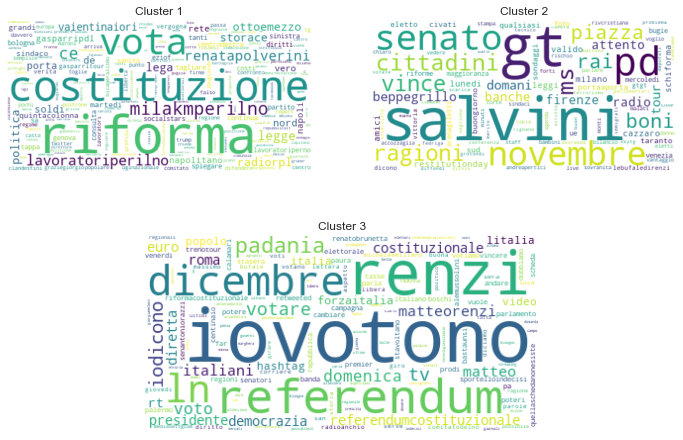

In [10]:
clusters_wordcloud(clusters, "no")

In [11]:
## Create word cloud for clusters
def k_core_ts(data, support=None):
    fig = plt.figure(constrained_layout=True, figsize=(24,14))
    grid = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
    subgrid = grid[0].subgridspec(1, 2)
    grid_axes = [subgrid[0, 0], subgrid[0, 1], grid[1, 0]]
    for i in range(1, 4):
        ts = data.loc[data.graph_k_core == i]
        ts.number_of_tweets = ts.groupby(["term"]).number_of_tweets.transform(lambda x: zscore(x))
        fig.add_subplot(grid_axes[i-1])
        sns.set(font_scale=1.5)
        sns.set_style("whitegrid")
        g = sns.lineplot(data=ts, x="date", y="number_of_tweets", hue="term")
        g.set(xlabel='Date', ylabel='Number of Tweets (Normalized)')
        plt.xticks(rotation=45)
        plt.tight_layout()
    plt.savefig(
        'temporal_analysis/figures/k_cores_{}.png'.format(support)
    )
    plt.show()

In [12]:
## K Core Timeseries
k_core_timeseries_yes = pd.read_csv("temporal_analysis/k_core_timeseries_yes.csv")
k_core_timeseries_no = pd.read_csv("temporal_analysis/k_core_timeseries_no.csv")
k_core_timeseries_no.date = pd.to_datetime(k_core_timeseries_no.date)
k_core_timeseries_yes.date = pd.to_datetime(k_core_timeseries_yes.date)

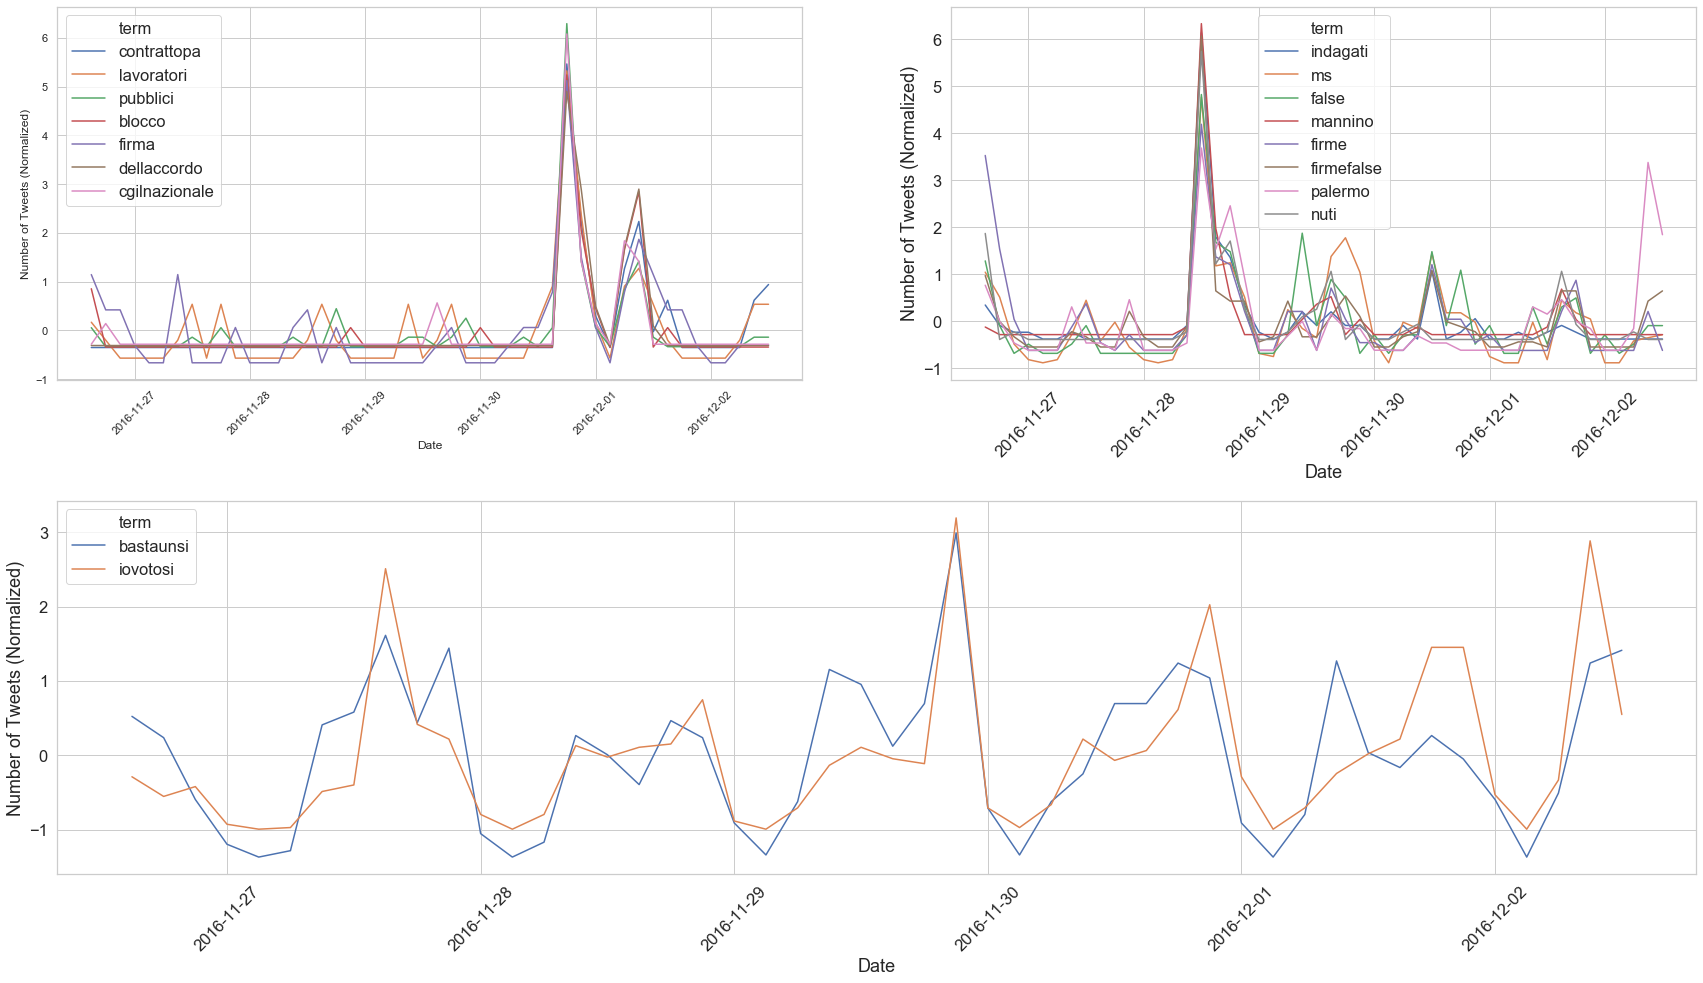

In [13]:
k_core_ts(k_core_timeseries_yes, "yes")

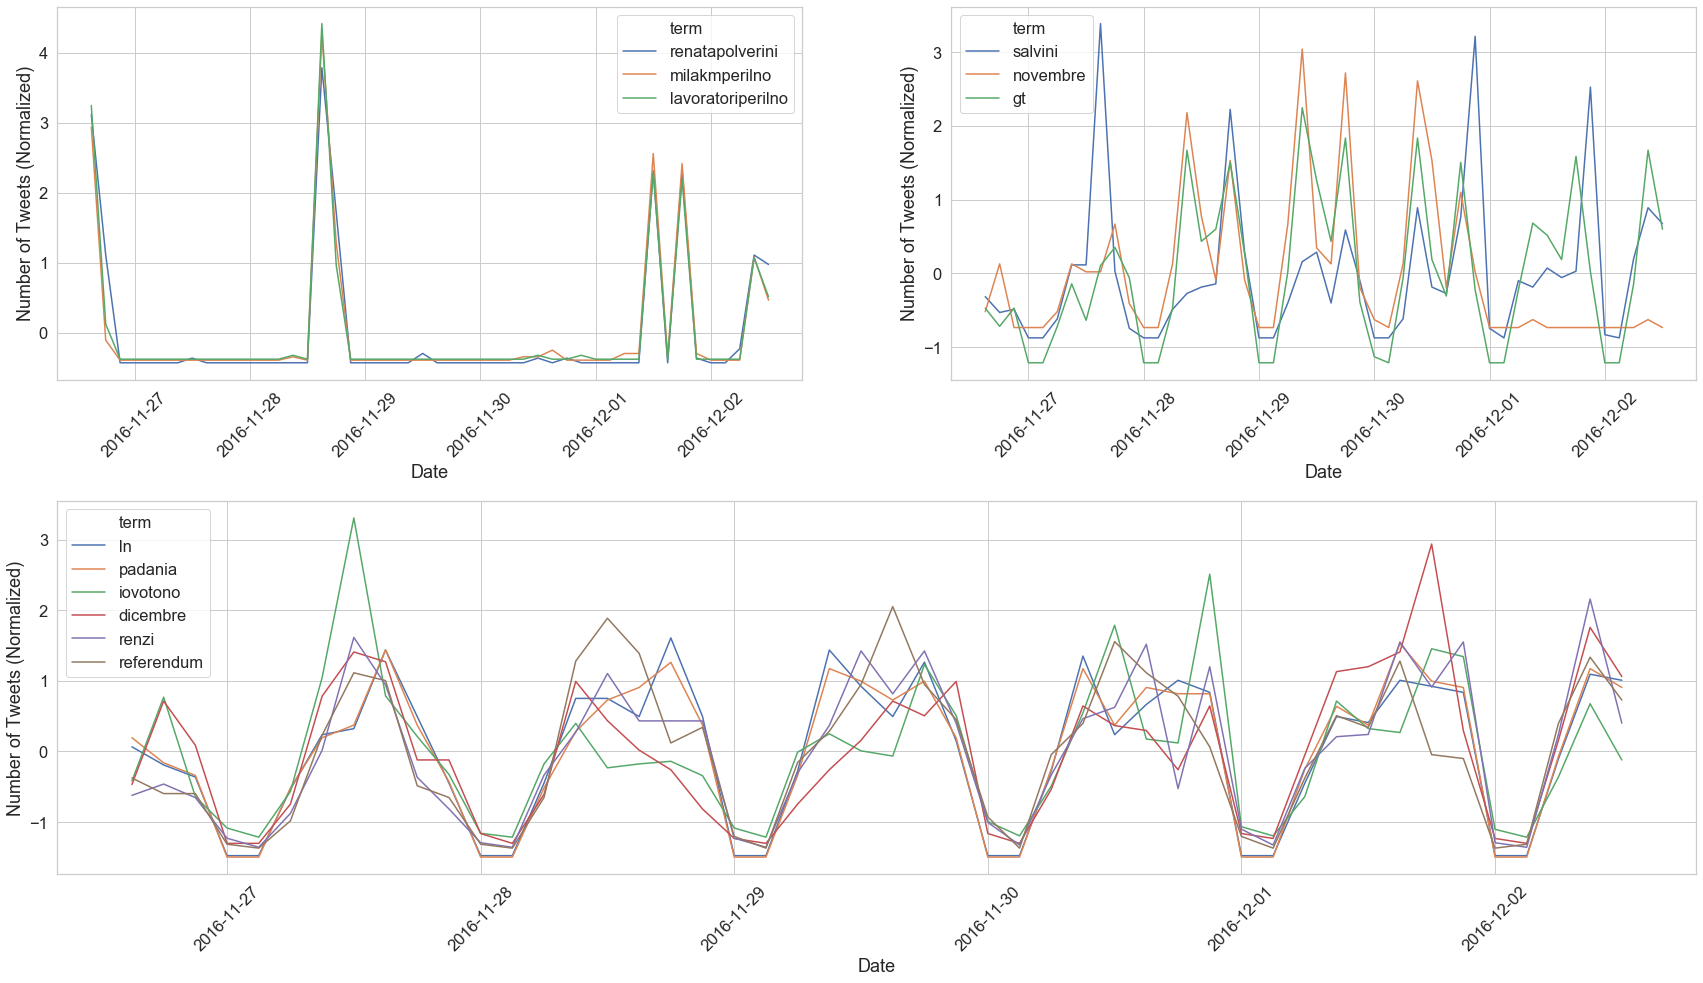

In [14]:
k_core_ts(k_core_timeseries_no, "no")

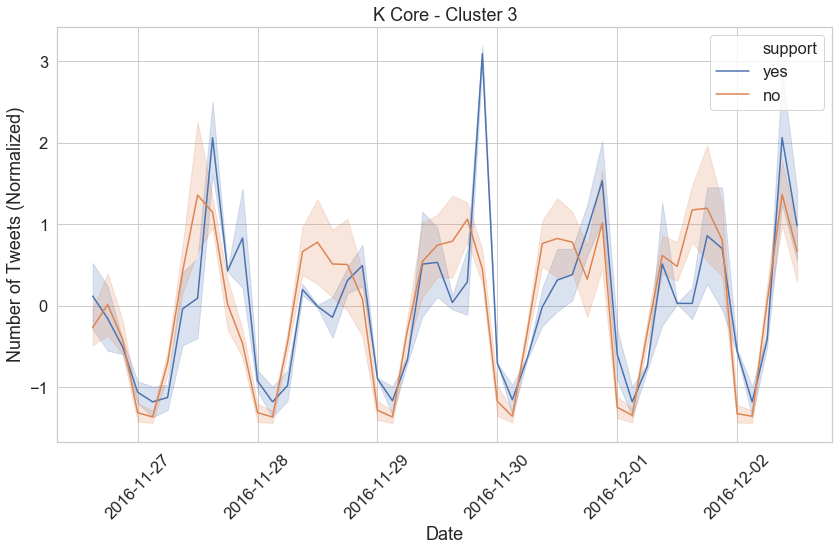

In [15]:
k_core_3_yes = k_core_timeseries_yes.loc[k_core_timeseries_yes.graph_k_core == 3]
k_core_3_no = k_core_timeseries_no.loc[k_core_timeseries_no.graph_k_core == 3]

k_core_3_yes["support"] = "yes"
k_core_3_no["support"] = "no"

k_core_3 = pd.concat([k_core_3_yes, k_core_3_no])
k_core_3.number_of_tweets = k_core_3.groupby(
    ["term"]
).number_of_tweets.transform(lambda x: zscore(x))
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.lineplot(data=k_core_3, x="date", y="number_of_tweets", hue="support")
g.set(xlabel='Date', ylabel='Number of Tweets (Normalized)', title="K Core - Cluster 3")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('temporal_analysis/figures/k_core_cluster_3.png')

In [16]:
users_support = pd.read_csv("identifying_yes_no_supporters/users_support.csv")

In [17]:
users_support.groupby(["support"]).user.count()

support
Neutral    40531
No          7532
Yes         3564
Name: user, dtype: int64

In [18]:
users_support.groupby(["support"]).number_of_tweets.sum()

support
Neutral     89381
No         215501
Yes        126698
Name: number_of_tweets, dtype: int64

In [19]:
users_hits_no = pd.read_csv("identifying_yes_no_supporters/users_hits_no.csv")
users_kpp_no = pd.read_csv("identifying_yes_no_supporters/kpp_score_no.csv")

In [20]:
users_hits_no.sort_values("authority_score", ascending=False).head(10)

,user,hub_score,authority_score,centrality_score
4780,fattoquotidiano,0.01125,0.12150,0.25823
4131,beppe_grillo,0.00344,0.10361,0.08799
493,civati,0.01137,0.08818,0.26800
5972,La7tv,0.00297,0.07905,0.06830
4759,lucatelese,0.00183,0.07606,0.04204
2003,PiazzapulitaLA7,0.01288,0.07555,0.29560
3773,ultimenotizie,0.01723,0.07513,0.39572
3996,GiorgiaMeloni,0.00572,0.07444,0.13210
2029,Mov5Stelle,0.00334,0.06989,0.07842
5437,NichiVendola,0.01113,0.06988,0.25686


In [21]:
users_hits_no.sort_values("centrality_score", ascending=False).head(10)

,user,hub_score,authority_score,centrality_score
2162,domenicoformic3,0.02906,0.00589,0.66667
4735,italse,0.02882,0.01487,0.66157
255,GASPARECARLINI,0.02841,0.00423,0.65401
4415,Didi1648,0.02688,0.00364,0.61718
1989,AurelioToro,0.02640,0.01032,0.60587
777,babylonboss,0.02598,0.01454,0.59663
2847,pippodido1,0.02574,0.00310,0.59065
798,soniabetz1,0.02448,0.03068,0.58953
3935,Giangiagainst,0.02551,0.01842,0.58531
2869,LemGiuseppe,0.02527,0.00696,0.58000


In [22]:
users_kpp_no.sort_values("kpp_score", ascending=False).head(10)

,user,kpp_score
0,senantoniorazzi,45705
2,flavia_marzano,34293
3,oinot49,34293
4,QuagliarielloG,34293
5,iLGae75,34293
6,mauroev,34293
1,matteosalvinimi,34293
7,alegio957,34282
8,ConversioneOrg,34282
9,molotov00,34282


In [23]:
users_hits_yes = pd.read_csv("identifying_yes_no_supporters/users_hits_yes.csv")
users_kpp_yes = pd.read_csv("identifying_yes_no_supporters/kpp_score_yes.csv")

In [24]:
users_hits_yes.sort_values("authority_score", ascending=False).head(10)

,user,hub_score,authority_score,centrality_score
1566,matteorenzi,0.00671,0.12701,0.15544
1752,repubblicait,0.00104,0.11881,0.02384
2117,lauraboldrini,0.01591,0.08070,0.36519
338,Montecitorio,0.00643,0.07192,0.14767
2199,graziano_delrio,0.01217,0.06886,0.28159
1757,angealfa,0.00600,0.06786,0.13848
2189,pdnetwork,0.01048,0.06706,0.28544
2041,serracchiani,0.00601,0.06555,0.14237
788,nomfup,0.01740,0.06231,0.40149
1794,nzingaretti,0.01195,0.06223,0.27471


In [25]:
users_hits_yes.sort_values("centrality_score", ascending=False).head(10)

,user,hub_score,authority_score,centrality_score
493,angelinascanu,0.01729,0.00993,0.73032
383,57_mimmo,0.02904,0.00602,0.67032
2276,AntonellaGramig,0.02437,0.00958,0.60352
1229,AS3691,0.02619,0.00809,0.60135
2091,paolocaccamo68,0.02543,0.00215,0.58895
2335,danielecina,0.02468,0.02601,0.57360
85,siperilsud1,0.02446,0.00233,0.56711
1513,gioicaro,0.02445,0.00238,0.56255
2578,SteAlbamonte,0.02377,0.01469,0.54931
45,martinorosario2,0.02374,0.00297,0.54516


In [26]:
users_kpp_yes.sort_values("kpp_score", ascending=False).head(10)

,user,kpp_score
0,matteorenzi,34293.0
1,Montecitorio,34293.0
2,angelerrimo,34282.0
3,flavagno,34282.0
677,claudioliga63,22859.0
907,nerodiseppia56,22859.0
905,VittorioBotti,22859.0
904,AntonioRepossi,22859.0
903,POAxSI,22859.0
902,andrearossi76,22859.0


In [27]:
## Spread of Influence
spread_of_influence_lpa_m = pd.read_csv("spread_of_influence/spread_of_influence_lpa_m.csv")
spread_of_influence_lpa_m2 = pd.read_csv("spread_of_influence/spread_of_influence_lpa_m2.csv")
spread_of_influence_lpa_k = pd.read_csv("spread_of_influence/spread_of_influence_lpa_k.csv")


spread_of_influence_modified_lpa_m = pd.read_csv("spread_of_influence/spread_of_influence_modified_lpa_m.csv")
spread_of_influence_modified_lpa_m2 = pd.read_csv("spread_of_influence/spread_of_influence_modified_lpa_m2.csv")
spread_of_influence_modified_lpa_k = pd.read_csv("spread_of_influence/spread_of_influence_modified_lpa_k.csv")

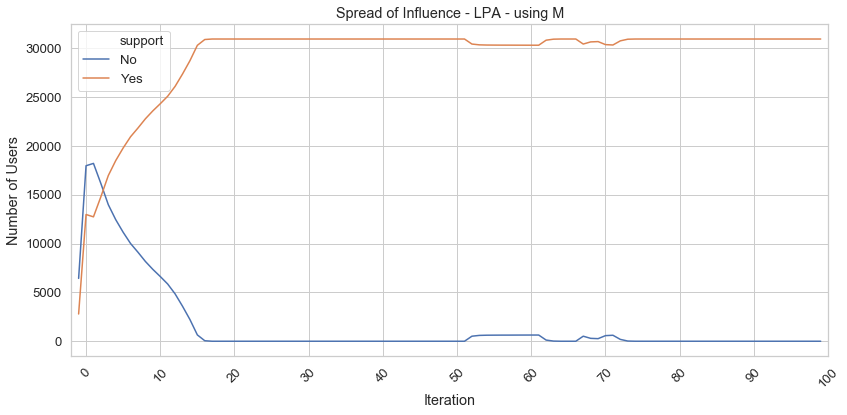

In [28]:
spread_of_influence_lpa_m = spread_of_influence_lpa_m.loc[spread_of_influence_lpa_m.support != "Neutral"]

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
g = sns.lineplot(data=spread_of_influence_lpa_m, x="iteration", y="n", hue="support")
g.set(
    xlabel='Iteration', 
    ylabel='Number of Users', 
    title="Spread of Influence - LPA - using M", 
    xlim = (spread_of_influence_lpa_m.iteration.min()-1, spread_of_influence_lpa_m.iteration.max()+1)
)
plt.xticks(np.arange(0, 110, step=10), rotation=45)

plt.tight_layout()
plt.savefig('spread_of_influence/figures/lpa_m.png')

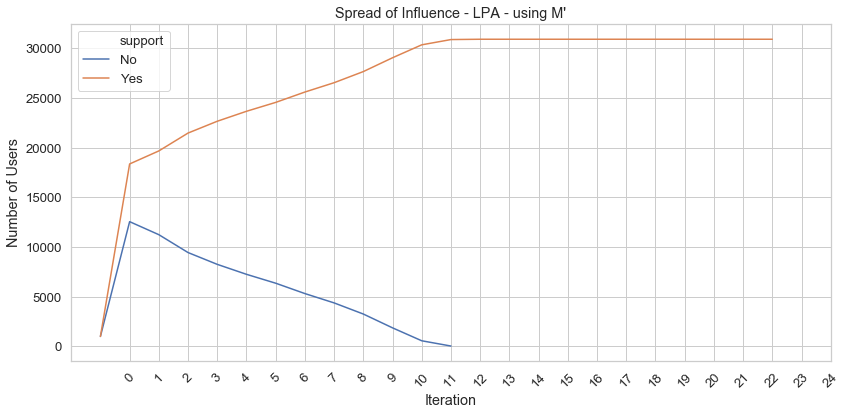

In [29]:
spread_of_influence_lpa_m2 = spread_of_influence_lpa_m2.loc[spread_of_influence_lpa_m2.support != "Neutral"]

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
g = sns.lineplot(data=spread_of_influence_lpa_m2, x="iteration", y="n", hue="support")
g.set(
    xlabel='Iteration', 
    ylabel='Number of Users', 
    title="Spread of Influence - LPA - using M'", 
    xlim = (spread_of_influence_lpa_m2.iteration.min()-1, spread_of_influence_lpa_m2.iteration.max()+1)
)
plt.xticks(np.arange(0, 25, step=1), rotation=45)


plt.tight_layout()
plt.savefig('spread_of_influence/figures/lpa_m2.png')

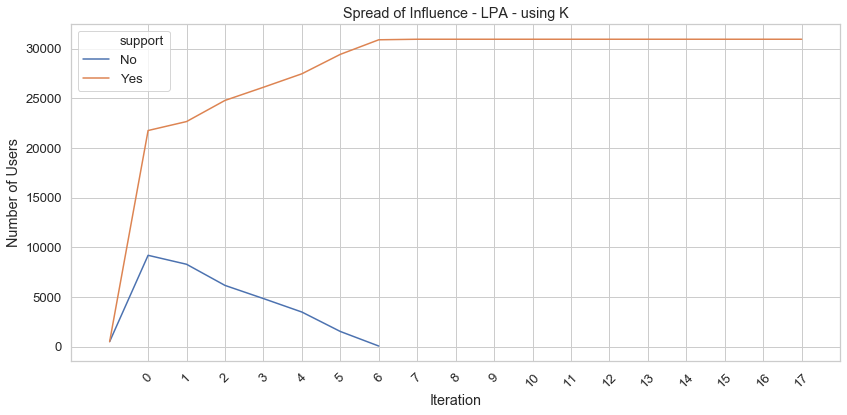

In [30]:
spread_of_influence_lpa_k = spread_of_influence_lpa_k.loc[spread_of_influence_lpa_k.support != "Neutral"]

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
g = sns.lineplot(data=spread_of_influence_lpa_k, x="iteration", y="n", hue="support")
g.set(
    xlabel='Iteration', 
    ylabel='Number of Users', 
    title="Spread of Influence - LPA - using K", 
    xlim = (spread_of_influence_lpa_k.iteration.min()-1, spread_of_influence_lpa_k.iteration.max()+1)
)

plt.xticks(np.arange(0, 18, step=1), rotation=45)

plt.tight_layout()
plt.savefig('spread_of_influence/figures/lpa_k.png')

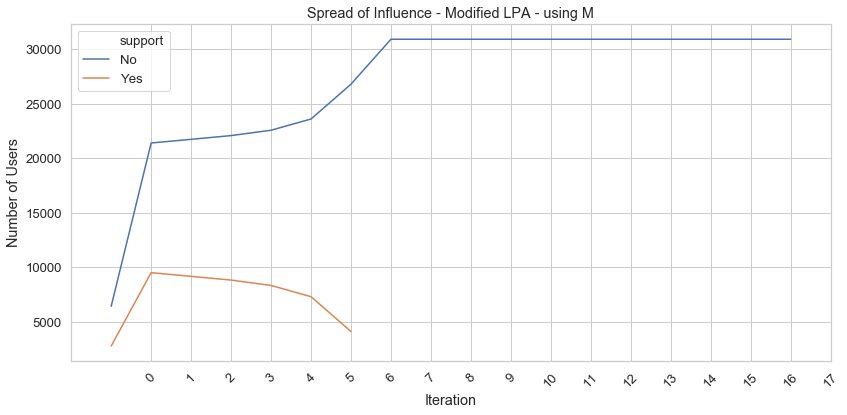

In [31]:
spread_of_influence_modified_lpa_m = spread_of_influence_modified_lpa_m.loc[spread_of_influence_modified_lpa_m.support != "Neutral"]

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
g = sns.lineplot(data=spread_of_influence_modified_lpa_m, x="iteration", y="n", hue="support")
g.set(
    xlabel='Iteration', 
    ylabel='Number of Users', 
    title="Spread of Influence - Modified LPA - using M", 
    xlim = (spread_of_influence_modified_lpa_m.iteration.min()-1, spread_of_influence_modified_lpa_m.iteration.max()+1)
)
plt.xticks(np.arange(0, 18, step=1), rotation=45)
plt.tight_layout()
plt.savefig('spread_of_influence/figures/modified_lpa_m.png')

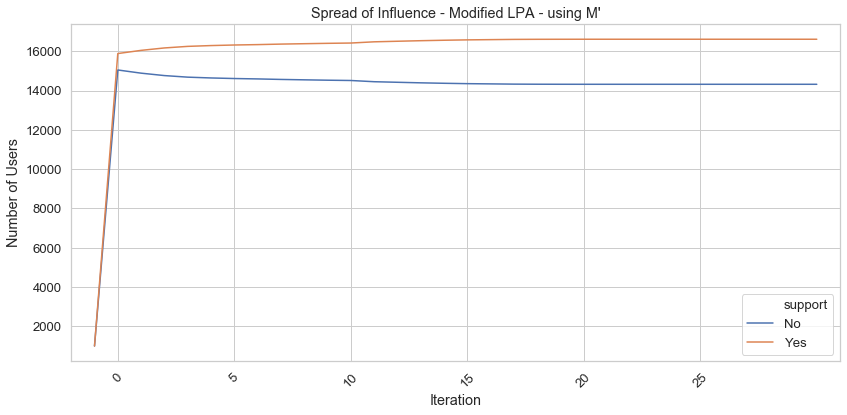

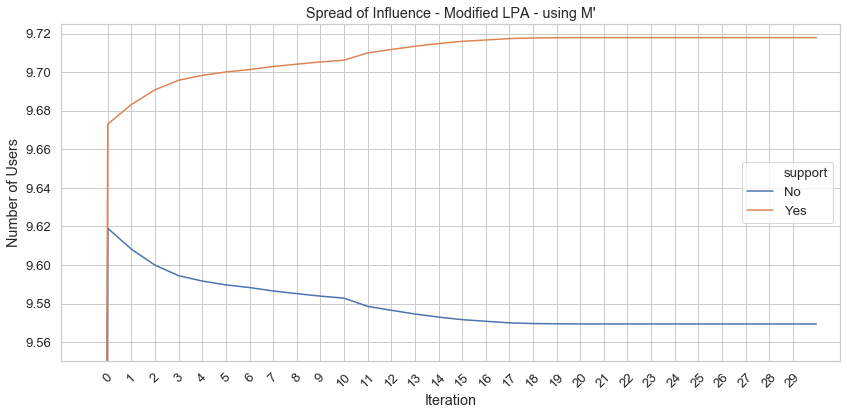

In [32]:
spread_of_influence_modified_lpa_m2 = spread_of_influence_modified_lpa_m2.loc[spread_of_influence_modified_lpa_m2.support != "Neutral"]
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
g = sns.lineplot(data=spread_of_influence_modified_lpa_m2, x="iteration", y="n", hue="support")
g.set(
    xlabel='Iteration', 
    ylabel='Number of Users', 
    title="Spread of Influence - Modified LPA - using M'", 
    xlim = (spread_of_influence_modified_lpa_m2.iteration.min()-1, spread_of_influence_modified_lpa_m2.iteration.max()+1)
)
plt.xticks(np.arange(0, 30, step=5), rotation=45)


plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('spread_of_influence/figures/modified_lpa_m2.png')

spread_of_influence_modified_lpa_m2.n = np.log(spread_of_influence_modified_lpa_m2.n)
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
g = sns.lineplot(data=spread_of_influence_modified_lpa_m2, x="iteration", y="n", hue="support")
g.set(
    xlabel='Iteration', 
    ylabel='Number of Users', 
    title="Spread of Influence - Modified LPA - using M'", 
    xlim = (spread_of_influence_modified_lpa_m2.iteration.min()-1, spread_of_influence_modified_lpa_m2.iteration.max()+1),
    ylim = (9.55, 9.725)
)
plt.xticks(np.arange(0, 30, step=1), rotation=45)

plt.tight_layout()
plt.savefig('spread_of_influence/figures/modified_lpa_log_m2.png')

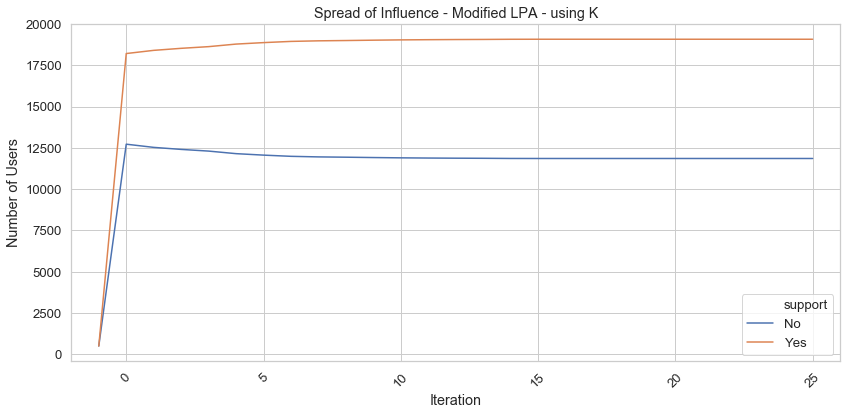

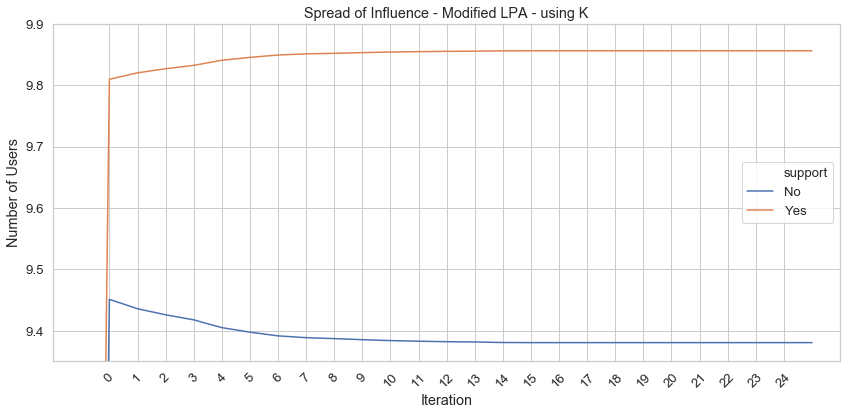

In [33]:
spread_of_influence_modified_lpa_k = spread_of_influence_modified_lpa_k.loc[spread_of_influence_modified_lpa_k.support != "Neutral"]
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
g = sns.lineplot(data=spread_of_influence_modified_lpa_k, x="iteration", y="n", hue="support")
g.set(
    xlabel='Iteration', 
    ylabel='Number of Users', 
    title="Spread of Influence - Modified LPA - using K", 
    xlim = (spread_of_influence_modified_lpa_k.iteration.min()-1, spread_of_influence_modified_lpa_k.iteration.max()+1)
)
plt.xticks(np.arange(0, 30, step=5), rotation=45)

plt.tight_layout()
plt.savefig('spread_of_influence/figures/modified_lpa_k.png')

spread_of_influence_modified_lpa_k.n = np.log(spread_of_influence_modified_lpa_k.n)
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
g = sns.lineplot(data=spread_of_influence_modified_lpa_k, x="iteration", y="n", hue="support")
g.set(
    xlabel='Iteration', 
    ylabel='Number of Users', 
    title="Spread of Influence - Modified LPA - using K", 
    xlim = (spread_of_influence_modified_lpa_k.iteration.min()-1, spread_of_influence_modified_lpa_k.iteration.max()+1),
    ylim = (9.35, 9.9)
)
plt.xticks(np.arange(0, 25, step=1), rotation=45)

plt.tight_layout()
plt.savefig('spread_of_influence/figures/modified_lpa_log_k.png')